In [1]:
import qutip as qt
import numpy as np

import os
os.chdir('/Users/ngdnhtien/Codespace/bqec@huikhoon')

%config InlineBackend.figure_formats = ['svg']

I first construct a single-mode Hamiltonian

In [51]:
r1 = ((4.626*0.115)/0.119 + 0.400/0.119)
r2 = 0.05
r3 = 1.25
r4 = 0.24

omega_c = 5.324
alpha = 0.125

dimTransmon = 15
dimCavity = 20

omega_10 = omega_c - alpha
delta_ac = r1 * alpha 
g_ac = r2 * delta_ac 
delta_dc = r3 * alpha
Omega_d = np.sqrt(r4) * np.abs(delta_dc)

omega_a = omega_10 + delta_ac
omega_d = omega_10 + delta_dc

print('r1, r2, r3, r4 = ', r1, r2, r3, r4)
print('delta_ac, delta_dc, Omega_d, g_ac = ', delta_ac, delta_dc, Omega_d, g_ac)
print(dimTransmon, dimCavity)

# Initialize annihilation operators
a_op = qt.tensor(qt.qeye(dimTransmon), qt.destroy(dimCavity))
c_op = qt.tensor(qt.destroy(dimTransmon), qt.qeye(dimCavity))
n_op = a_op.dag() * a_op

# Construct the effective Hamiltonian
c0_priori = 0
c1_priori = 1e-8
c2_priori = 1e-9

H_eff = (2*np.pi) * ((omega_a + c0_priori) * n_op + c1_priori * (n_op)**2 + c2_priori * (n_op)**3)
psi0 = qt.tensor(qt.basis(dimTransmon, 0), qt.coherent(dimCavity, 3.0))
T = 5000
times = np.linspace(0, T, T+1)

res = qt.mesolve(H_eff, psi0, times, progress_bar=True, options=qt.Options(nsteps=20_000))

r1, r2, r3, r4 =  7.8318487394958 0.05 1.25 0.24
delta_ac, delta_dc, Omega_d, g_ac =  0.978981092436975 0.15625 0.07654655446197431 0.04894905462184875
15 20
10.0%. Run time:  15.94s. Est. time left: 00:00:02:23
20.0%. Run time:  32.20s. Est. time left: 00:00:02:08
30.0%. Run time:  47.78s. Est. time left: 00:00:01:51
40.0%. Run time:  62.90s. Est. time left: 00:00:01:34
50.0%. Run time:  77.93s. Est. time left: 00:00:01:17
60.0%. Run time:  92.47s. Est. time left: 00:00:01:01
70.0%. Run time: 106.95s. Est. time left: 00:00:00:45
80.0%. Run time: 121.13s. Est. time left: 00:00:00:30
90.0%. Run time: 134.80s. Est. time left: 00:00:00:14
Total run time: 149.23s


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

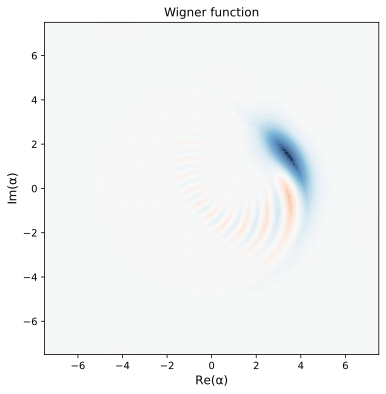

In [52]:
qt.plot_wigner(res.states[-1].ptrace(1))

I then tryna fit the evolution

In [3]:
n_op = a_op.dag() * a_op

def H_eff(c0):
    return c0 * n_op

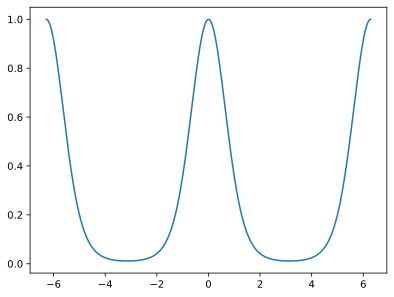

In [316]:
fid_list = []
for c0 in np.linspace(-2*np.pi, 2*np.pi, 1001):
    evol_state = ((-1j*(6*9_999+c0)*n_op).expm() * psi0).unit()
    fid_list.append(qt.fidelity(evol_state,res.states[-1]))

plt.plot(np.linspace(-2*np.pi, 2*np.pi, 1001), fid_list)

In [317]:
def objective(args):

    c0, c1 = args 

    evol_state = ((-1j*(c0*tlist[-1]+2*c1*np.pi)*n_op).expm() * psi0).unit()
    infd = np.abs(1 - qt.fidelity(evol_state, res.states[-1]))

    return infd

In [333]:
from scipy.optimize import minimize

x0 = [6, 0]
solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-7)

solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00010296342551785465
             x: [ 6.000e+00  2.337e-04]
           nit: 50
          nfev: 111
 final_simplex: (array([[ 6.000e+00,  2.337e-04],
                       [ 6.000e+00,  2.338e-04],
                       [ 6.000e+00,  2.337e-04]]), array([ 1.030e-04,  1.030e-04,  1.030e-04]))

In [334]:
evol_state = ((-1j*(solution.x[0]*tlist[-1]+2*solution.x[1]*np.pi)*n_op).expm() * psi0).unit()
print(qt.fidelity(evol_state, res.states[-1]))

0.9998970365744821
